<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="100%" height="100%"/></p></a>

<center><em>Content Copyright by HongLab, Inc.</em></center>

# 2차원 푸리에 변환 - 이미지 피팅

## 1차원에서 2차원으로

- **1D**: $f(t) = \sum_n c_n \sin(nt)$ → waves along time
- **2D**: $f(x,y) = \sum_{m,n} c_{mn} \sin(mx)\sin(ny)$ → waves across a plane


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

## 이미지 준비

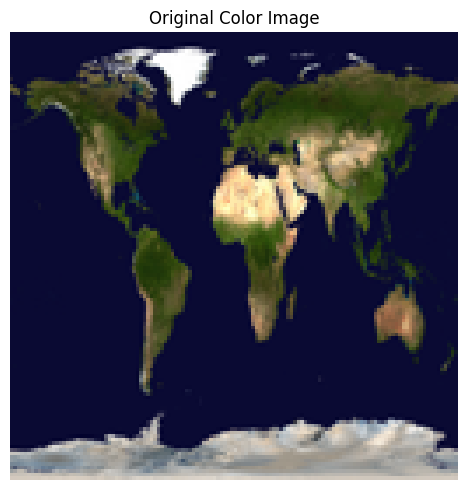

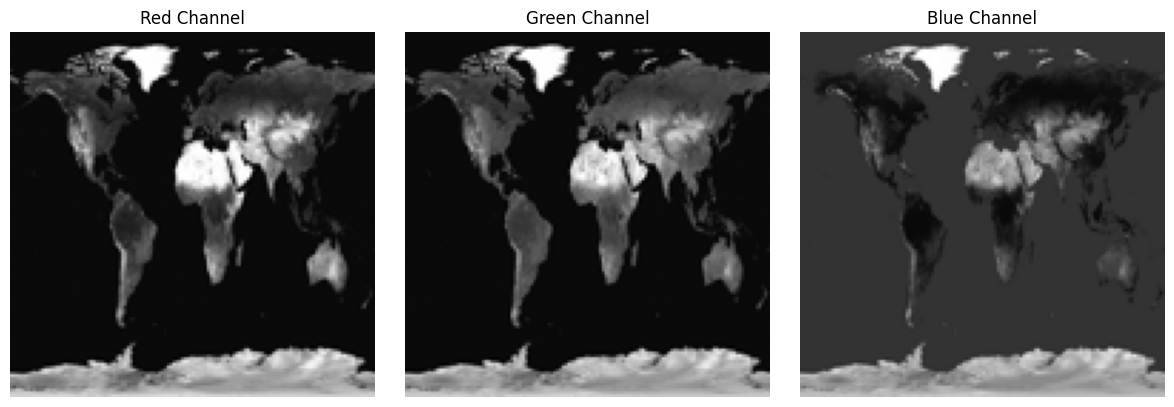

Image shape: (128, 128, 3)
Image range: [0.000, 1.000]


In [2]:
# Load the image
img = Image.open("Blue_Marble_2002.png")

# Resize to a smaller size for faster computation
img = img.resize((128, 128))

# Convert to RGB array and normalize to [0, 1]
img_rgb = np.array(img.convert('RGB')) / 255.0

# Display original image
plt.figure(figsize=(5, 5))
plt.imshow(img_rgb)
plt.title("Original Color Image")
plt.axis('off')
plt.tight_layout()
plt.show()

# Show individual channels
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, (color, name) in enumerate(zip([img_rgb[:,:,0], img_rgb[:,:,1], img_rgb[:,:,2]], ['Red', 'Green', 'Blue'])):
    axes[i].imshow(color, cmap='gray', vmin=0, vmax=1)
    axes[i].set_title(f'{name} Channel')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print(f"Image shape: {img_rgb.shape}")
print(f"Image range: [{img_rgb.min():.3f}, {img_rgb.max():.3f}]")

## 1차원 단면 예시

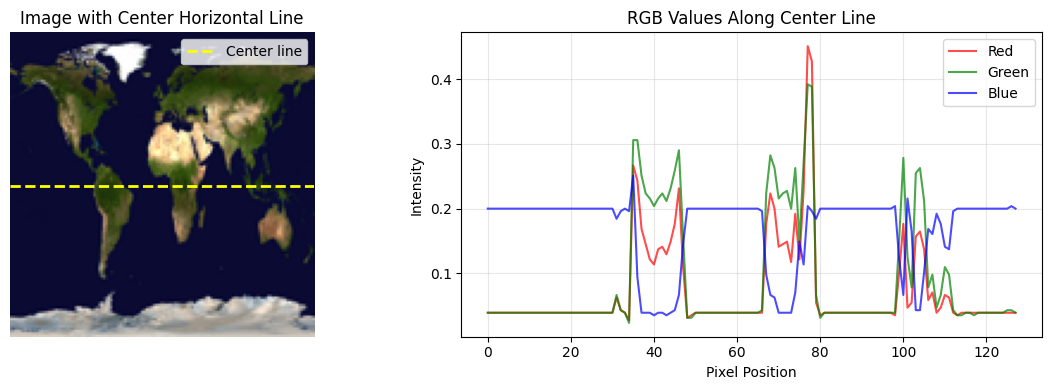

1D signal length: 128 pixels


In [3]:
# Extract the center horizontal line (for each RGB channel)
center_row = img_rgb.shape[0] // 2
line_rgb = img_rgb[center_row, :]  # Shape: (128, 3)

# Show where we're taking the line from
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.axhline(y=center_row, color='yellow', linewidth=2, linestyle='--', label='Center line')
plt.title("Image with Center Horizontal Line")
plt.legend()
plt.axis('off')

# Plot the RGB values along this line
plt.subplot(1, 2, 2)
x_positions = np.arange(len(line_rgb))
plt.plot(x_positions, line_rgb[:, 0], 'r-', label='Red', alpha=0.7)
plt.plot(x_positions, line_rgb[:, 1], 'g-', label='Green', alpha=0.7)
plt.plot(x_positions, line_rgb[:, 2], 'b-', label='Blue', alpha=0.7)
plt.xlabel('Pixel Position')
plt.ylabel('Intensity')
plt.title('RGB Values Along Center Line')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"1D signal length: {len(line_rgb)} pixels")

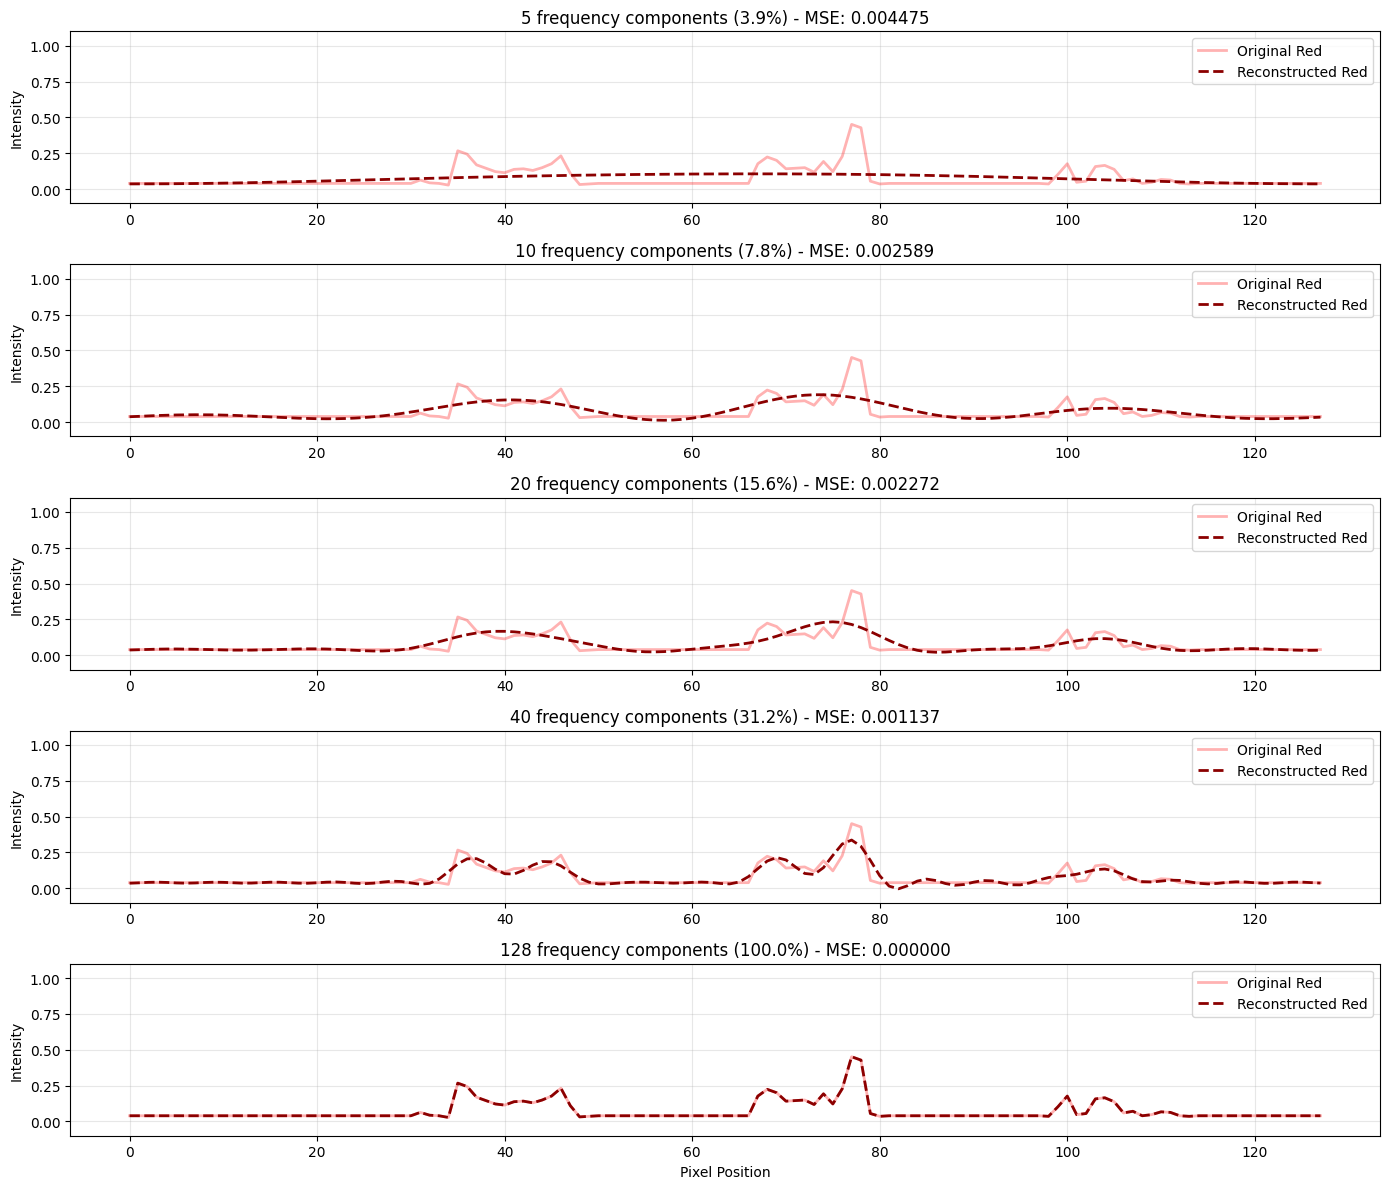


Observation: With just a few low-frequency components, we capture the overall trend.
As we add more components, we recover finer details and sharper transitions.


In [4]:
# Reconstruct using different numbers of frequency components
def reconstruct_1d_with_n_components(fft_coeffs, n_components):
    """Keep only the n_components lowest frequencies"""
    fft_filtered = np.zeros_like(fft_coeffs, dtype=complex)
    center = len(fft_coeffs) // 2
    
    # Keep n_components around the center (low frequencies)
    half_n = n_components // 2
    start = max(0, center - half_n)
    end = min(len(fft_coeffs), center + half_n)
    fft_filtered[start:end] = fft_coeffs[start:end]
    
    # Inverse FFT
    reconstructed = np.fft.ifft(np.fft.ifftshift(fft_filtered)).real
    return reconstructed

# Compute 1D FFT for red channel
line_red = line_rgb[:, 0]
fft_1d_red = np.fft.fft(line_red)
fft_1d_shifted_red = np.fft.fftshift(fft_1d_red)

# Try different numbers of components (using red channel only for simplicity)
n_components_list = [5, 10, 20, 40, 128]  # 128 = all components

fig, axes = plt.subplots(len(n_components_list), 1, figsize=(14, 12))

for idx, n_comp in enumerate(n_components_list):
    # Reconstruct red channel only
    line_recon_red = reconstruct_1d_with_n_components(fft_1d_shifted_red, n_comp)
    
    # Calculate error
    mse = np.mean((line_red - line_recon_red)**2)
    percentage = (n_comp / len(line_rgb)) * 100
    
    # Plot
    x = np.arange(len(line_rgb))
    axes[idx].plot(x, line_red, 'r-', alpha=0.3, linewidth=2, label='Original Red')
    axes[idx].plot(x, line_recon_red, 'darkred', linewidth=2, linestyle='--', label='Reconstructed Red')
    
    axes[idx].set_ylabel('Intensity')
    axes[idx].set_title(f'{n_comp} frequency components ({percentage:.1f}%) - MSE: {mse:.6f}')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(loc='upper right', fontsize=10)
    axes[idx].set_ylim(-0.1, 1.1)

axes[-1].set_xlabel('Pixel Position')
plt.tight_layout()
plt.show()

print("\nObservation: With just a few low-frequency components, we capture the overall trend.")
print("As we add more components, we recover finer details and sharper transitions.")

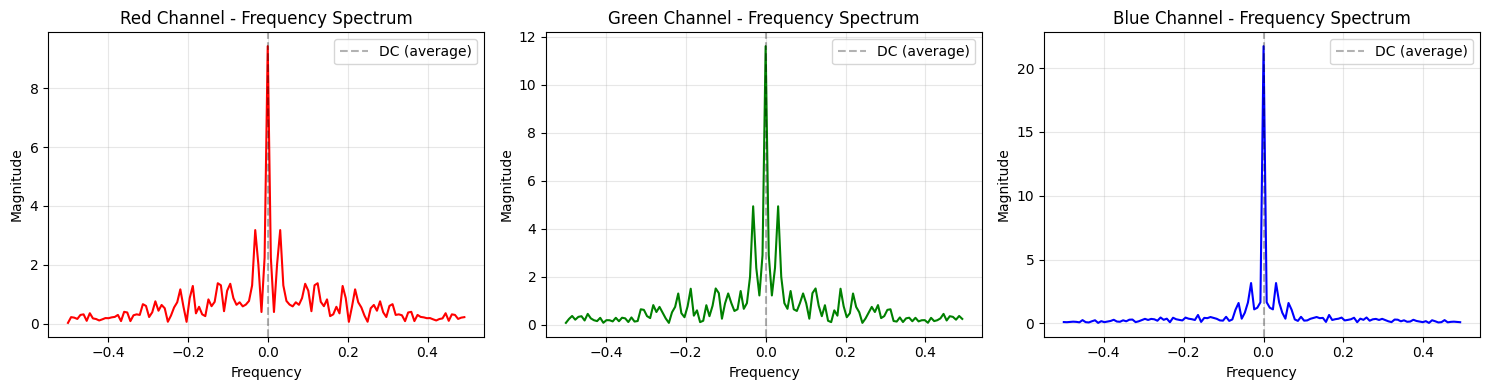

Note: Low frequencies (near center) are stronger → smooth variations
      High frequencies (at edges) are weaker → fine details


In [5]:
# Compute 1D FFT for each channel
fft_1d_rgb = np.zeros_like(line_rgb, dtype=complex)

for c in range(3):
    fft_1d_rgb[:, c] = np.fft.fft(line_rgb[:, c])

# Shift zero frequency to center for visualization
fft_1d_shifted_rgb = np.fft.fftshift(fft_1d_rgb, axes=0)

# Visualize the 1D frequency spectrum
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for c, (color_name, color_code) in enumerate(zip(['Red', 'Green', 'Blue'], ['r', 'g', 'b'])):
    magnitude = np.abs(fft_1d_shifted_rgb[:, c])
    frequencies = np.fft.fftshift(np.fft.fftfreq(len(line_rgb)))
    
    axes[c].plot(frequencies, magnitude, color=color_code, linewidth=1.5)
    axes[c].set_xlabel('Frequency')
    axes[c].set_ylabel('Magnitude')
    axes[c].set_title(f'{color_name} Channel - Frequency Spectrum')
    axes[c].grid(True, alpha=0.3)
    axes[c].axvline(x=0, color='black', linestyle='--', alpha=0.3, label='DC (average)')
    axes[c].legend()

plt.tight_layout()
plt.show()

print("Note: Low frequencies (near center) are stronger → smooth variations")
print("      High frequencies (at edges) are weaker → fine details")

### 2D 주파수 스펙트럼 읽는 방법

The spectrum visualization below shows frequency information as an image. **Each pixel's position represents a specific frequency pair (m, n)**:

**What the visualization shows:**
- **Horizontal position** → frequency in x-direction (left-right oscillations)
- **Vertical position** → frequency in y-direction (up-down oscillations)  
- **Brightness/Color** → magnitude (how much that frequency contributes)

**Key regions:**
- **Center pixel (0, 0)** = DC component (average brightness/color, no oscillation)
- **Near center** = low frequencies (smooth gradients, overall structure)
- **Far from center** = high frequencies (edges, textures, fine details)

**Reading the pattern:**
- Bright center with dim edges → smooth image (sky, gradients)
- Energy spread throughout → detailed/textured image (foliage, buildings)
- Horizontal/vertical lines → edges in the perpendicular direction

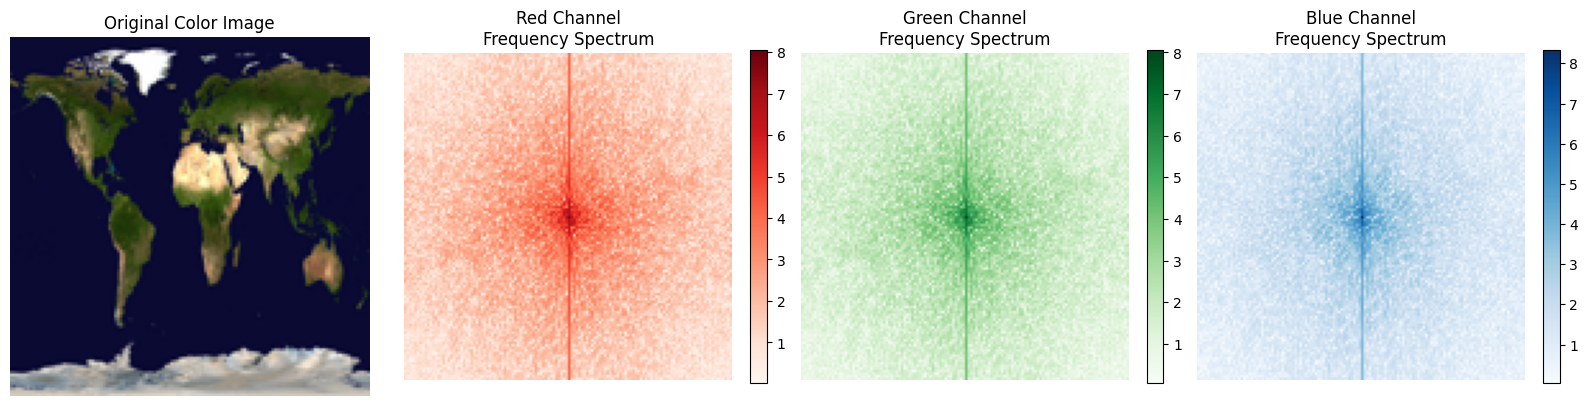

In [6]:
# Compute 2D FFT for each color channel
fft_coeffs_rgb = np.zeros(img_rgb.shape, dtype=complex)
fft_coeffs_shifted_rgb = np.zeros(img_rgb.shape, dtype=complex)

for c in range(3):  # RGB channels
    fft_coeffs_rgb[:, :, c] = np.fft.fft2(img_rgb[:, :, c])
    fft_coeffs_shifted_rgb[:, :, c] = np.fft.fftshift(fft_coeffs_rgb[:, :, c])

# Visualize the magnitude spectrum for each channel (log scale)
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(img_rgb)
axes[0].set_title("Original Color Image")
axes[0].axis('off')

for c, (color_name, cmap) in enumerate(zip(['Red', 'Green', 'Blue'], ['Reds', 'Greens', 'Blues'])):
    magnitude_spectrum = np.log(1 + np.abs(fft_coeffs_shifted_rgb[:, :, c]))
    im = axes[c+1].imshow(magnitude_spectrum, cmap=cmap)
    axes[c+1].set_title(f'{color_name} Channel\nFrequency Spectrum')
    axes[c+1].axis('off')
    plt.colorbar(im, ax=axes[c+1], fraction=0.046)

plt.tight_layout()
plt.show()

## 점진적인 이미지 복원

Now let's reconstruct the image using progressively more Fourier coefficients. We'll keep only the frequencies within a certain radius from the center (low frequencies).

### Image Compression via Frequency Selection

This demonstrates the fundamental principle of **lossy image compression**:

**How it works:**
1. **Transform**: Convert the image to frequency domain using FFT
2. **Truncate**: Keep only the most important coefficients (usually low frequencies)
3. **Store**: Save only the selected coefficients (massive data reduction)
4. **Reconstruct**: Apply inverse FFT to recover an approximation of the original

**Why this achieves compression:**
- Original image: 128×128×3 = 49,152 pixel values to store
- With 5% coefficients: Only ~2,458 coefficients per channel need to be stored (95% reduction!)
- Most visual information is in low frequencies, so we lose little perceptual quality

**Key advantages:**
- **Efficient encoding**: Natural images have most energy concentrated in low frequencies
- **Perceptual optimization**: Human vision is less sensitive to high-frequency loss
- **Adjustable quality**: Trade-off between file size (number of coefficients) and quality (MSE)

**Real-world applications:**
- **JPEG**: Uses Discrete Cosine Transform (DCT, similar to Fourier) on 8×8 blocks
- **JPEG 2000**: Uses wavelets (another frequency-domain transform)
- **Video codecs**: H.264, H.265 use similar frequency-domain compression

The reconstruction below shows how increasing the radius (keeping more frequencies) progressively improves image quality.

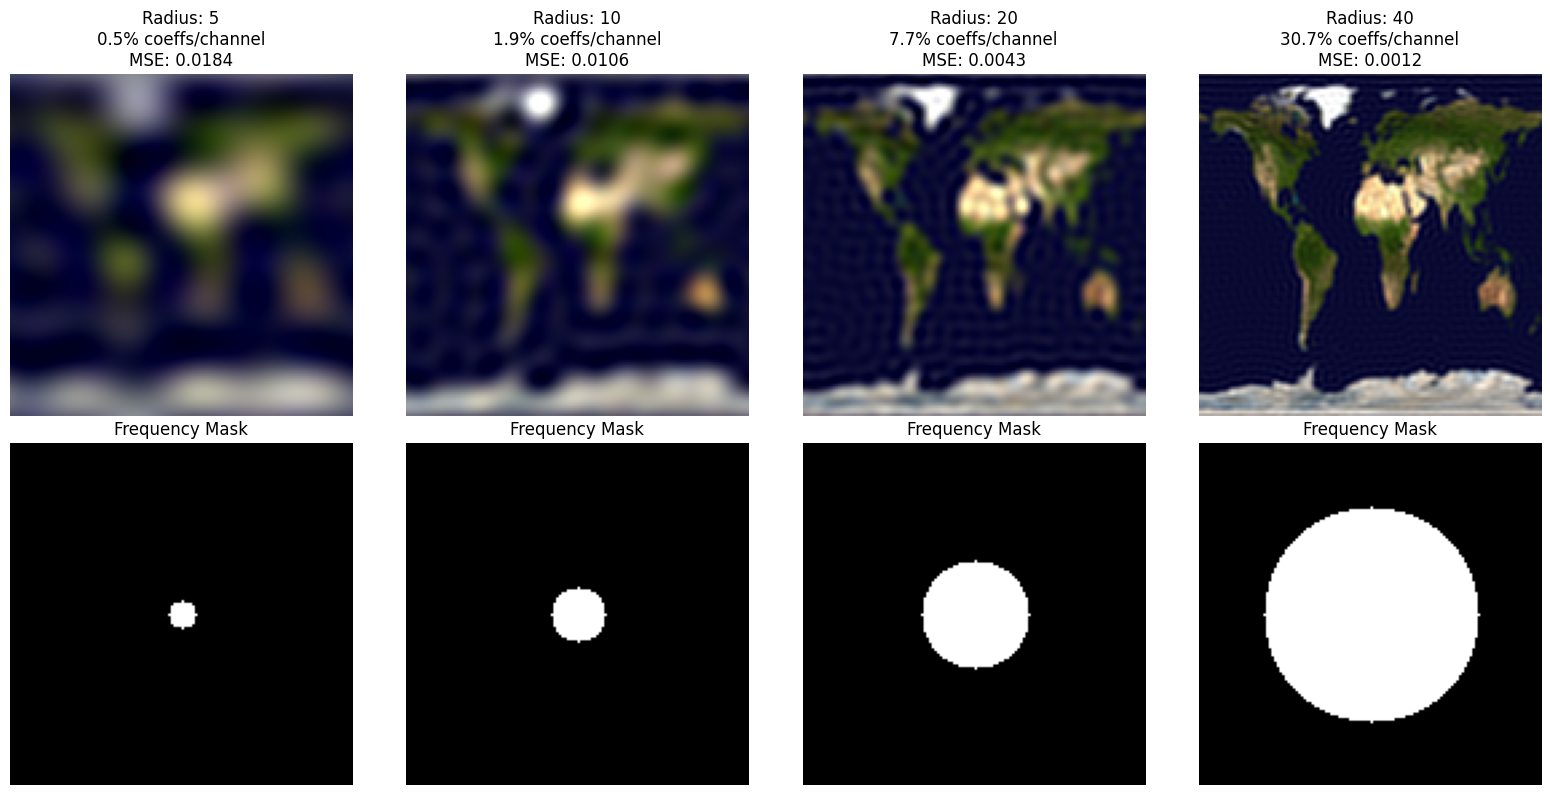

In [7]:
def reconstruct_with_radius_color(fft_coeffs_shifted_rgb, radius):
    """
    Reconstruct color image using only frequencies within a given radius from center.
    Applies the same frequency mask to all RGB channels.
    """
    H, W, C = fft_coeffs_shifted_rgb.shape
    center_h, center_w = H // 2, W // 2
    
    # Create a mask to keep only frequencies within the radius
    mask = np.zeros((H, W), dtype=bool)
    y, x = np.ogrid[:H, :W]
    mask = ((x - center_w)**2 + (y - center_h)**2) <= radius**2
    
    # Reconstruct each channel
    img_reconstructed = np.zeros((H, W, C))
    
    for c in range(C):
        # Apply mask to coefficients
        fft_filtered = fft_coeffs_shifted_rgb[:, :, c].copy()
        fft_filtered[~mask] = 0
        
        # Inverse FFT to get reconstructed channel
        fft_filtered_unshifted = np.fft.ifftshift(fft_filtered)
        img_reconstructed[:, :, c] = np.fft.ifft2(fft_filtered_unshifted).real
    
    # Clip to valid range
    img_reconstructed = np.clip(img_reconstructed, 0, 1)
    
    return img_reconstructed, mask

# Try different radii
radii = [5, 10, 20, 40]

fig, axes = plt.subplots(2, len(radii), figsize=(16, 8))

for i, radius in enumerate(radii):
    img_recon, mask = reconstruct_with_radius_color(fft_coeffs_shifted_rgb, radius)
    
    # Calculate number of coefficients used (per channel)
    num_coeffs = np.sum(mask)
    total_coeffs = mask.size
    percentage = (num_coeffs / total_coeffs) * 100
    
    # Calculate MSE
    mse = np.mean((img_rgb - img_recon)**2)
    
    # Show reconstructed image
    axes[0, i].imshow(img_recon)
    axes[0, i].set_title(f'Radius: {radius}\n{percentage:.1f}% coeffs/channel\nMSE: {mse:.4f}')
    axes[0, i].axis('off')
    
    # Show frequency mask
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f'Frequency Mask')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## 3D Visualization of Frequency Spectrum

A 3D surface plot helps visualize the magnitude distribution in the frequency domain. Lower frequencies (center) typically have higher magnitudes, while higher frequencies (edges) decay.

In [8]:
# Enable interactive 3D plots (requires ipympl: pip install ipympl)
%matplotlib widget

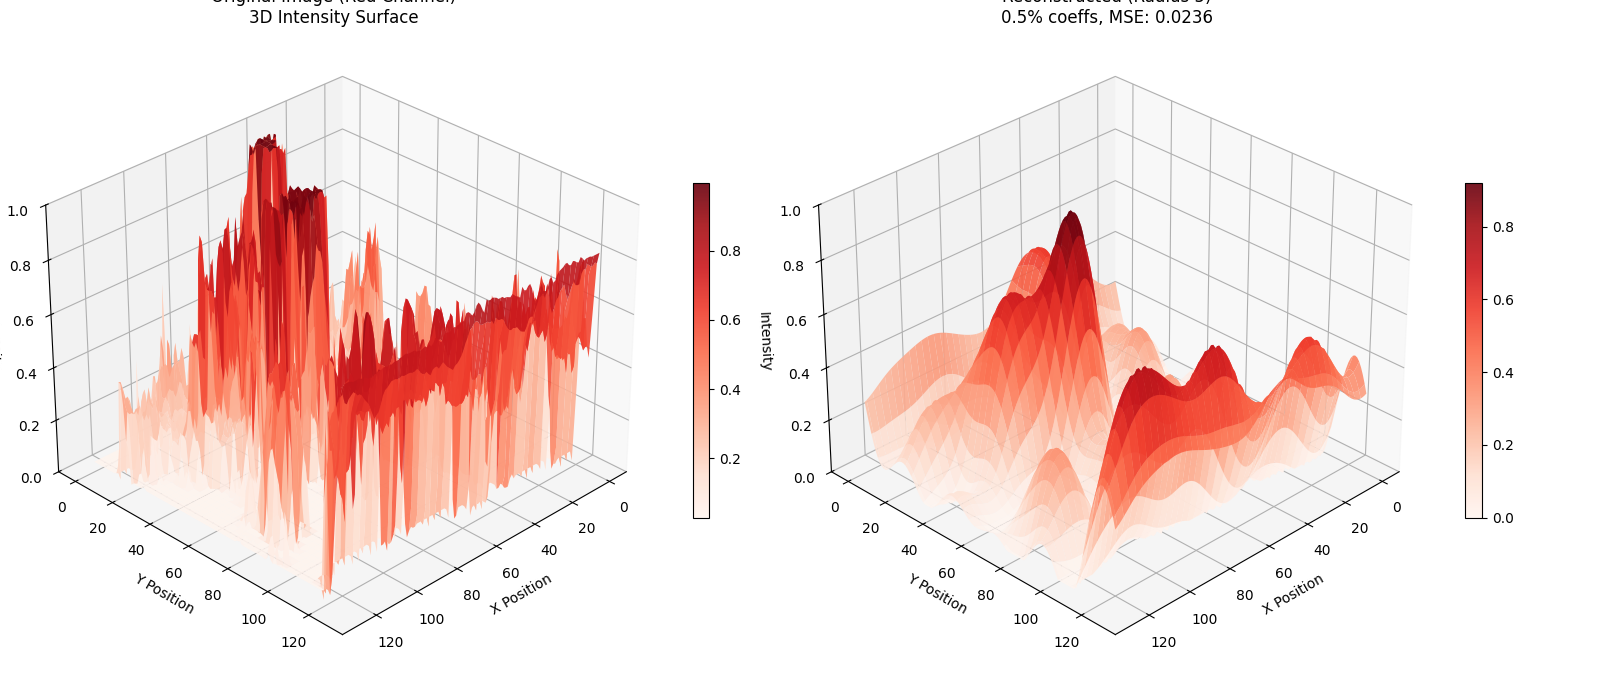

Radius 5 reconstruction:
  - Coefficients used: 81 out of 16384
  - Percentage: 0.49%
  - MSE: 0.023564
  - The 3D surface shows how low-pass filtering smooths out fine details
  - High-frequency details (sharp edges, textures) are lost


In [9]:
from mpl_toolkits.mplot3d import Axes3D

# Use the red channel for 3D visualization (simpler than showing all RGB)
img_red = img_rgb[:, :, 0]

# Reconstruct with radius 5
img_recon_r5, mask_r5 = reconstruct_with_radius_color(fft_coeffs_shifted_rgb, radius=5)
img_recon_red = img_recon_r5[:, :, 0]

# Create coordinate grids
H, W = img_red.shape
x = np.arange(W)
y = np.arange(H)
X, Y = np.meshgrid(x, y)

# Create figure with two 3D subplots
fig = plt.figure(figsize=(16, 7))

# 1. Original image as 3D surface
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, Y, img_red, cmap='Reds', edgecolor='none', alpha=0.9)
ax1.set_title('Original Image (Red Channel)\n3D Intensity Surface', fontsize=12)
ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
ax1.set_zlabel('Intensity')
ax1.view_init(elev=30, azim=45)
ax1.set_zlim(0, 1)
fig.colorbar(surf1, ax=ax1, shrink=0.5)

# 2. Reconstructed image with radius 5
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, Y, img_recon_red, cmap='Reds', edgecolor='none', alpha=0.9)

num_coeffs = np.sum(mask_r5)
percentage = (num_coeffs / mask_r5.size) * 100
mse = np.mean((img_red - img_recon_red)**2)

ax2.set_title(f'Reconstructed (Radius 5)\n{percentage:.1f}% coeffs, MSE: {mse:.4f}', fontsize=12)
ax2.set_xlabel('X Position')
ax2.set_ylabel('Y Position')
ax2.set_zlabel('Intensity')
ax2.view_init(elev=30, azim=45)
ax2.set_zlim(0, 1)
fig.colorbar(surf2, ax=ax2, shrink=0.5)

plt.tight_layout()
plt.show()

print(f"Radius 5 reconstruction:")
print(f"  - Coefficients used: {num_coeffs} out of {mask_r5.size}")
print(f"  - Percentage: {percentage:.2f}%")
print(f"  - MSE: {mse:.6f}")
print(f"  - The 3D surface shows how low-pass filtering smooths out fine details")
print(f"  - High-frequency details (sharp edges, textures) are lost")